In [1]:
import sys
print(sys.version)

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]


In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [3]:
#what is the current working directory?
import os
os.getcwd()

'C:\\Users\\maden\\Documents\\DataProjects\\WiDS2020\\HiddenFigures\\02_code'

In [4]:
#Dependencies
import numpy as np
import pandas as pd
import re

from datetime import date, datetime

#set df scrolling
pd.set_option("display.max.columns",None)
#set df precision to 2 decimals for now...
pd.set_option("display.precision",2)
pd.set_option('display.max_rows',500)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
enc = OneHotEncoder(handle_unknown = 'ignore')
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

from string import ascii_letters
from pprint import pprint



In [5]:
#Import Train Data
dfpath_train = "../01_data/training_NumericOnly.csv"
dfpath_test = "../01_data/testing_NumericOnly.csv"

df_train = pd.read_csv(dfpath_train)
print(df_train.shape)

df_test = pd.read_csv(dfpath_test)
print(df_test.shape)

target_col = 'hospital_death'

(91713, 178)
(39308, 178)


# Load Test / Train Data

# Preprocessing

In [6]:
#Later, do binary encoding and get dummies for categorical columns here

In [34]:
#How many NA records are in each column?
df_train.isna().sum()

hospital_id                      0
hospital_death                   0
age                              0
bmi                              0
elective_surgery                 0
height                           0
icu_id                           0
pre_icu_los_days                 0
readmission_status               0
weight                           0
albumin_apache                   0
apache_2_diagnosis               0
apache_3j_diagnosis              0
arf_apache                       0
bilirubin_apache                 0
bun_apache                       0
creatinine_apache                0
fio2_apache                      0
gcs_eyes_apache                  0
gcs_motor_apache                 0
gcs_unable_apache                0
gcs_verbal_apache                0
glucose_apache                   0
heart_rate_apache                0
hematocrit_apache                0
intubated_apache                 0
map_apache                       0
paco2_apache                     0
pao2_apache         

In [35]:
df_test.isna().sum()

hospital_id                      0
age                              0
bmi                              0
elective_surgery                 0
height                           0
icu_id                           0
pre_icu_los_days                 0
readmission_status               0
weight                           0
albumin_apache                   0
apache_2_diagnosis               0
apache_3j_diagnosis              0
arf_apache                       0
bilirubin_apache                 0
bun_apache                       0
creatinine_apache                0
fio2_apache                      0
gcs_eyes_apache                  0
gcs_motor_apache                 0
gcs_unable_apache                0
gcs_verbal_apache                0
glucose_apache                   0
heart_rate_apache                0
hematocrit_apache                0
intubated_apache                 0
map_apache                       0
paco2_apache                     0
pao2_apache                      0
ph_apache           

In [36]:
#process categorical columns  (can use nunique to find these)
#must identify columns that might have medical codes in them
#in the example, they defined these as columns of more than 7 and less than 800 unique values

# print([c for c in df.columns if 7 <df[c].nunique()<800])

#identify columns that need encoded as numeric with label encoder  (so they are not currently a numeric)
# categorical_Cols = [c for c in df.columns if (1<df[c].nunique()) \
#                     & (df[c].dtype != np.number) & (df[c].dtype != int)]
# print(categorical_Cols)

#First fill in missing values in both datasets in these columns with ''
# df[categorical_Cols] = df[categorical_Cols].fillna("")

#Check to make sure it worked
# df[categorical_Cols].isna().sum()

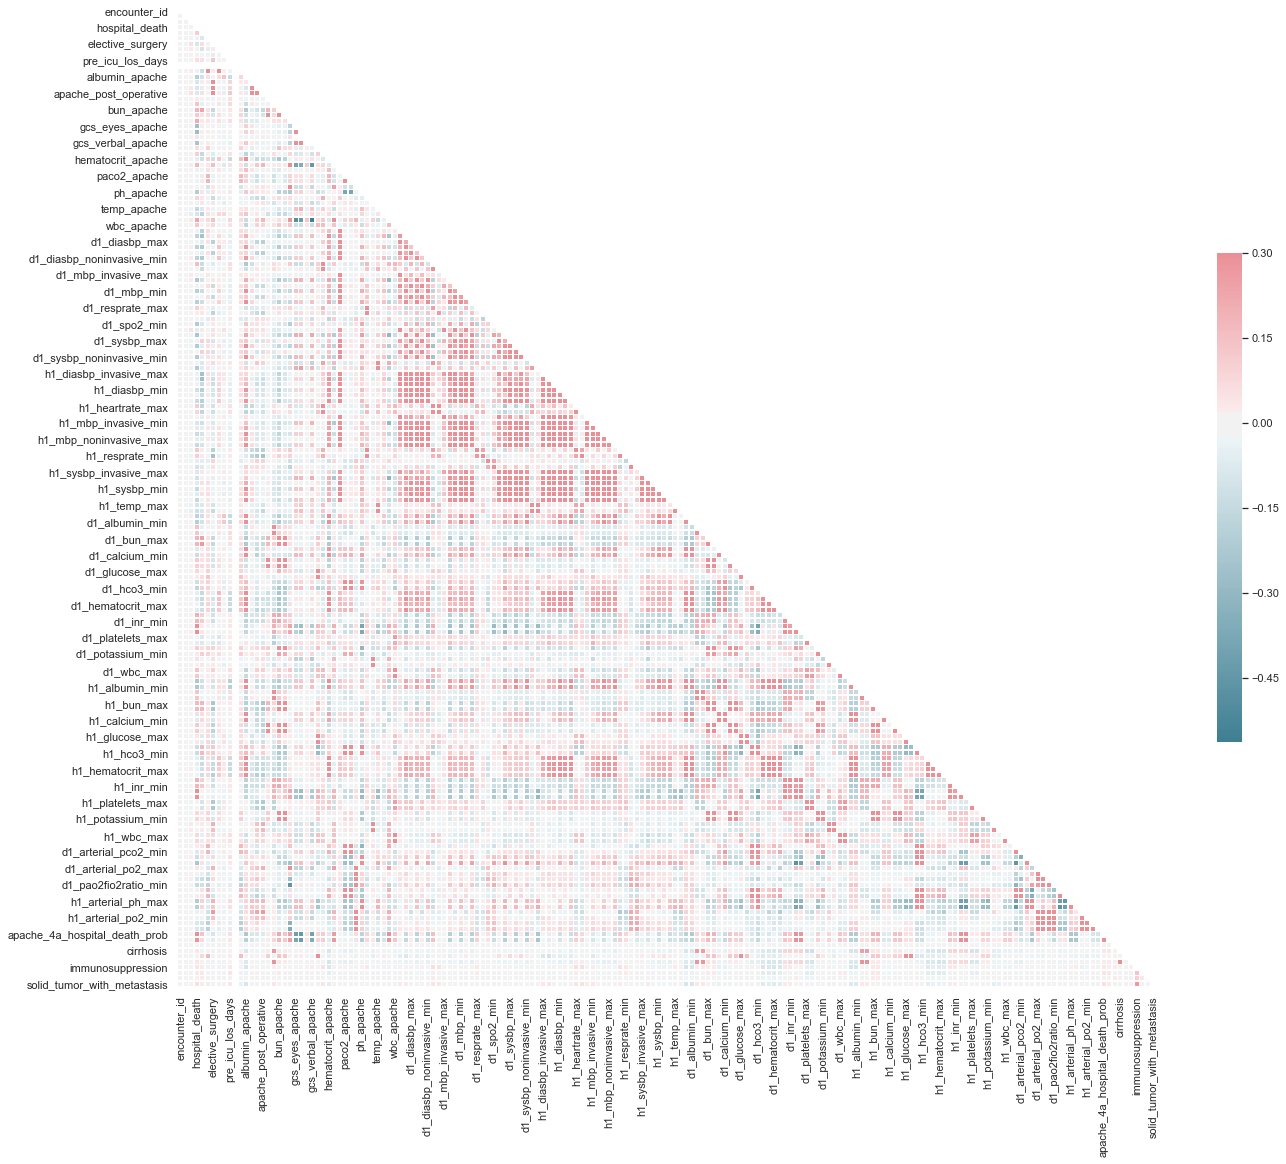

In [10]:
sns.set(style="white")
#compute the correlation matrix
corr = df_train.corr()

#generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
###
### Compare the correlation between features and remove one of two features that have a correlation higher than 0.9

#There are some areas with heavy correlation
#Another way to reduce features is to remove some of the features with correlation higher than a set value.  
#Here, I will select 0.9

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = df_train.columns[columns]
df_train = df_train[selected_columns]
df_test = df_test[selected_columns.drop(['hospital_death'])]

df_train.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_calcium_max,d1_calcium_min,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_potassium_max,d1_potassium_min,d1_sodium_max,h1_albumin_max,h1_calcium_max,h1_glucose_max,h1_potassium_max,h1_sodium_max,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_ph_max,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,66154,25312,118,0,68.0,22.73,0,180.3,92,5.42e-01,0,73.9,2.3,113.0,502.01,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,39.5,37.5,8.5,7.4,109.0,19.0,15.0,8.9,NaN,NaN,1.3,1.0,233.0,4.0,3.4,136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,114252,59342,81,0,77.0,27.42,0,160.0,90,9.28e-01,0,70.2,NaN,108.0,203.01,0.0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0.0,46.0,37.0,51.0,7.45,33.0,145.0,35.1,NaN,1.0,12.7,NaN,NaN,95.0,31.0,118.0,72.0,NaN,NaN,120.0,38.0,32.0,12.0,100.0,70.0,NaN,NaN,159.0,67.0,36.3,35.1,NaN,NaN,61.0,48.0,114.0,100.0,NaN,NaN,85.0,57.0,31.0,28.0,95.0,70.0,NaN,NaN,95.0,71.0,36.3,36.3,8.6,8.0,128.0,27.0,26.0,11.3,1.3,1.3,3.5,3.5,557.0,4.2,3.8,145.0,NaN,8.6,145.0,4.2,145.0,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.00,7.45,51.0,51.0,51.0,0.47,0.29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,119783,50777,118,0,25.0,31.95,0,172.7,93,6.94e-04,0,95.3,NaN,122.0,703.03,0.0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0.0,68.0,NaN,NaN,NaN,37.0,NaN,36.7,NaN,0.0,NaN,NaN,NaN,88.0,48.0,96.0,68.0,NaN,NaN,102.0,68.0,21.0,8.0,98.0,91.0,NaN,NaN,148.0,105.0,37.0,36.7,NaN,NaN,88.0,58.0,96.0,78.0,NaN,NaN,91.0,83.0,20.0,16.0,98.0,91.0,NaN,NaN,148.0,124.0,36.7,36.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,79267,46918,118,0,81.0,22.64,1,165.1,92,6.94e-04,0,61.7,NaN,203.0,1206.03,0.0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1.0,60.0,30.0,142.0,7.39,4.0,NaN,34.8,NaN,1.0,8.0,62.0,30.0,48.0,42.0,116.0,92.0,92.0,52.0,84.0,84.0,23.0,7.0,100.0,95.0,164.0,78.0,158.0,84.0,38.0,34.8,62.0,44.0,62.0,44.0,100.0,96.0,92.0,71.0,92.0,71.0,12.0,11.0,100.0,99.0,136.0,106.0,136.0,106.0,35.6,34.8,NaN,NaN,88.0,NaN,NaN,11.6,1.6,1.1,NaN,NaN,198.0,5.0,3.5,NaN,NaN,NaN,NaN,NaN,NaN,37.0,27.0,7.44,7

In [12]:
df_test.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_calcium_max,d1_calcium_min,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_potassium_max,d1_potassium_min,d1_sodium_max,h1_albumin_max,h1_calcium_max,h1_glucose_max,h1_potassium_max,h1_sodium_max,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_ph_max,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,2,127112,7,56.0,21.10,0,180.3,1105,1.04e-01,0,68.6,3.7,301.0,405.01,0.0,NaN,19.0,0.67,NaN,2.0,5.0,0.0,1.0,276.0,105.0,42.0,0.0,57.0,NaN,NaN,NaN,5.0,134.0,36.6,1121.13,0.0,4.7,NaN,NaN,74.0,51.0,100.0,78.0,NaN,NaN,86.0,60.0,20.0,8.0,100.0,96.0,NaN,NaN,121.0,79.0,37.1,36.6,NaN,NaN,55.0,51.0,88.0,84.0,NaN,NaN,68.0,60.0,18.0,8.0,100.0,98.0,NaN,NaN,91.0,79.0,36.6,36.6,9.3,9.3,167.0,24.0,24.0,13.8,NaN,NaN,NaN,NaN,223.0,4.8,4.8,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,130737,178,NaN,19.50,1,145.0,1043,2.31e-01,0,41.0,NaN,217.0,1502.02,0.0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,4.0,NaN,60.0,NaN,0.0,53.0,NaN,NaN,NaN,37.0,NaN,37.0,843.44,0.0,NaN,NaN,NaN,65.0,31.0,73.0,60.0,NaN,NaN,108.0,53.0,33.0,16.0,99.0,90.0,NaN,NaN,148.0,83.0,37.7,36.6,NaN,NaN,50.0,44.0,60.0,60.0,NaN,NaN,80.0,80.0,16.0,16.0,94.0,92.0,NaN,NaN,121.0,96.0,36.6,36.6,8.0,8.0,100.0,31.0,31.0,9.9,NaN,NaN,NaN,NaN,93.0,4.4,4.4,140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,101458,86,66.0,32.52,1,170.2,1035,1.41e-01,0,94.2,NaN,302.0,1208.06,0.0,NaN,22.0,1.84,NaN,2.0,5.0,0.0,1.0,81.0,124.0,39.2,0.0,115.0,NaN,NaN,NaN,31.0,130.0,35.5,1728.00,0.0,14.8,85.0,57.0,85.0,57.0,117.0,86.0,110.0,71.0,110.0,71.0,28.0,10.0,100.0,95.0,172.0,102.0,172.0,102.0,37.5,35.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.7,8.4,81.0,22.0,19.0,12.7,NaN,NaN,NaN,NaN,184.0,4.7,4.5,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,48067,163,64.0,20.80,0,182.8,1078,2.08e-03,0,69.5,1.9,303.0,211.03,0.0,0.8,24.0,0.75,0.7,4.0,6.0,0.0,1.0,122.0,111.0,32.0,1.0,48.0,36.0,142.0,7.35,30.0,133.0,37.7,1434.41,1.0,9.7,NaN,NaN,63.0,42.0,111.0,60.0,NaN,NaN,76.0,48.0,35.0,15.0,100.0,92.0,NaN,NaN,115.0,69.0,38.4,37.5,NaN,NaN,62.0,57.0,111.0,102.0,NaN,NaN,76.0,65.0,26.0,23.0,95.0,93.0,NaN,NaN,115.0,92.0,38.0,38.0,7.9,7.4,122.0,22.0,20.0,11.0,1.4,1.4,0.8,0.8,248.0,4.1,4.0,138.0,1.9,7.4,122.0,4.0,133.0,36.0,36.0,7.37,7.35,142.0,57.0,202.86,114.0,NaN,NaN,NaN,NaN,0.19,0.17

# Handle NaN Values

In [13]:
#Handle the NaN values in the rows  (remove, impute, or find algorithm that allows them)

# #Example 1: Remove Missing Values  (Will significantly reduce our dataset)
# #drop columns with > 25% of rows with missing values  - How does this impact our dataset?
# threshold = int(len(df) * .5)
# print(threshold)
# df = df.dropna(thresh = threshold, axis = 1)
# df.head()

# Example 2:  Imputing  (mean,median,mode, randomly selected, value estimated from another model (liek nearest neighbors))
#Use the imputer function to replace the NaN values
#I liked this for help... https://www.kaggle.com/learn-forum/62035
imputer = SimpleImputer(missing_values = np.nan, strategy = "mean")
#Fit the data, function learns the stats
df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train))
df_test_imputed = pd.DataFrame(imputer.fit_transform(df_test))
#add titles back
df_train_imputed.columns = df_train.columns
df_test_imputed.columns = df_test.columns

df_train = df_train_imputed
df_train.head()

#Example 3: Select ML algorithm that allows NaN values



,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_calcium_max,d1_calcium_min,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_potassium_max,d1_potassium_min,d1_sodium_max,h1_albumin_max,h1_calcium_max,h1_glucose_max,h1_potassium_max,h1_sodium_max,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_ph_max,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,66154.0,25312.0,118.0,0.0,68.0,22.73,0.0,180.3,92.0,5.42e-01,0.0,73.90,2.3,113.0,502.01,0.0,0.40,31.00,2.51,0.6,3.00,6.00,0.00e+00,4.00,168.00,118.0,27.40,0.0,40.0,42.18,131.15,7.35,36.0,134.00,39.3,1738.28,0.0,14.10,46.00,32.00,68.0,37.0,119.0,72.0,66.00,40.00,89.0,46.0,34.0,10.0,100.0,74.0,122.00,64.00,131.0,73.0,39.9,37.2,67.97,56.14,68.0,63.0,119.0,108.0,94.88,75.97,86.0,85.0,26.00,18.00,100.0,74.0,138.7,114.83,131.0,115.0,39.50,37.50,8.50,7.40,109.00,19.00,15.00,8.90,1.6,1.48,1.30,1.00,233.00,4.00,3.40,136.00,3.03,8.28,167.99,4.2,138.24,45.25,38.43,7.39,7.32,165.91,103.51,285.67,223.52,7.34,163.84,144.15,244.4,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,114252.0,59342.0,81.0,0.0,77.0,27.42,0.0,160.0,90.0,9.28e-01,0.0,70.20,2.9,108.0,203.01,0.0,1.15,9.00,0.56,1.0,1.00,3.00,0.00e+00,1.00,145.00,120.0,36.90,0.0,46.0,37.00,51.00,7.45,33.0,145.00,35.1,1738.28,1.0,12.70,78.76,46.74,95.0,31.0,118.0,72.0,114.89,62.32,120.0,38.0,32.0,12.0,100.0,70.0,154.27,93.81,159.0,67.0,36.3,35.1,67.97,56.14,61.0,48.0,114.0,100.0,94.88,75.97,85.0,57.0,31.00,28.00,95.0,70.0,138.7,114.83,95.0,71.0,36.30,36.30,8.60,8.00,128.00,27.00,26.00,11.30,1.3,1.30,3.50,3.50,557.00,4.20,3.80,145.00,3.03,8.60,145.00,4.2,145.00,37.00,37.00,7.45,7.45,51.00,51.00,54.80,51.00,7.45,51.00,51.00,51.0,0.47,0.29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,119783.0,50777.0,118.0,0.0,25.0,31.95,0.0,172.7,93.0,6.94e-04,0.0,95.30,2.9,122.0,703.03,0.0,1.15,25.83,1.48,0.6,3.00,6.00,0.00e+00,5.00,160.33,102.0,32.99,0.0,68.0,42.18,131.15,7.35,37.0,137.97,36.7,1738.28,0.0,12.13,78.76,46.74,88.0,48.0,96.0,68.0,114.89,62.32,102.0,68.0,21.0,8.0,98.0,91.0,154.27,93.81,148.0,105.0,37.0,36.7,67.97,56.14,88.0,58.0,96.0,78.0,94.88,75.97,91.0,83.0,20.00,16.00,98.0,91.0,138.7,114.83,148.0,124.0,36.70,36.70,8.38,8.18,114.38,24.37,23.17,11.45,1.6,1.48,2.93,2.13,207.11,4.25,3.93,139.12,3.03,8.28,167.99,4.2,138.24,45.25,38.43,7.39,7.32,165.91,103.51,285.67,223.52,7.34,163.84,144.15,244.4,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,79267.0,46918.0,118.0,0.0,81.0,22.64,1.0,165.1,92.0,6.94e-04,0.0,61.70,2.9,203.0,1206.03,0.0,1.15,25.83,1.48,0.6,4.00,6.00,0.00e+00,5.00,185.00,114

In [14]:

df_test = df_test_imputed
df_test.head()


,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_calcium_max,d1_calcium_min,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_potassium_max,d1_potassium_min,d1_sodium_max,h1_albumin_max,h1_calcium_max,h1_glucose_max,h1_potassium_max,h1_sodium_max,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_ph_max,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,2.0,127112.0,7.0,56.00,21.10,0.0,180.30,1105.0,1.04e-01,0.0,68.6,3.70,301.0,405.01,0.0,1.33,19.00,0.67,0.6,2.0,5.0,0.0,1.0,276.0,105.0,42.00,0.0,57.0,42.12,134.05,7.35,5.0,134.0,36.6,1121.13,0.0,4.70,80.29,47.44,74.0,51.0,100.0,78.0,113.47,61.99,86.0,60.0,20.0,8.0,100.0,96.0,151.3,93.3,121.0,79.0,37.1,36.6,69.63,57.69,55.0,51.00,88.00,84.00,94.34,76.06,68.00,60.0,18.00,8.00,100.00,98.00,137.35,114.75,91.00,79.00,36.60,36.60,9.3,9.3,167.0,24.00,24.00,13.8,1.54,1.42,2.92,1.99,223.0,4.8,4.8,135.0,2.96,8.26,167.29,4.16,138.0,45.57,38.78,7.38,7.32,162.96,101.69,291.86,224.9,7.33,160.98,149.84,253.94,0.13,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,130737.0,178.0,61.31,19.50,1.0,145.00,1043.0,2.31e-01,0.0,41.0,2.84,217.0,1502.02,0.0,1.33,25.48,1.49,0.6,4.0,6.0,0.0,4.0,159.7,60.0,32.95,0.0,53.0,42.12,134.05,7.35,37.0,137.9,37.0,843.44,0.0,12.31,80.29,47.44,65.0,31.0,73.0,60.0,113.47,61.99,108.0,53.0,33.0,16.0,99.0,90.0,151.3,93.3,148.0,83.0,37.7,36.6,69.63,57.69,50.0,44.00,60.00,60.00,94.34,76.06,80.00,80.0,16.00,16.00,94.00,92.00,137.35,114.75,121.00,96.00,36.60,36.60,8.0,8.0,100.0,31.00,31.00,9.9,1.54,1.42,2.92,1.99,93.0,4.4,4.4,140.0,2.96,8.26,167.29,4.16,138.0,45.57,38.78,7.38,7.32,162.96,101.69,291.86,224.9,7.33,160.98,149.84,253.94,0.09,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.0,101458.0,86.0,66.00,32.52,1.0,170.20,1035.0,1.41e-01,0.0,94.2,2.84,302.0,1208.06,0.0,1.33,22.00,1.84,0.6,2.0,5.0,0.0,1.0,81.0,124.0,39.20,0.0,115.0,42.12,134.05,7.35,31.0,130.0,35.5,1728.00,0.0,14.80,85.00,57.00,85.0,57.0,117.0,86.0,110.00,71.00,110.0,71.0,28.0,10.0,100.0,95.0,172.0,102.0,172.0,102.0,37.5,35.5,69.63,57.69,75.6,61.71,92.94,84.05,94.34,76.06,90.55,77.6,22.32,16.78,98.22,95.44,137.35,114.75,133.31,115.04,36.75,36.63,8.7,8.4,81.0,22.00,19.00,12.7,1.54,1.42,2.92,1.99,184.0,4.7,4.5,135.0,2.96,8.26,167.29,4.16,138.0,45.57,38.78,7.38,7.32,162.96,101.69,291.86,224.9,7.33,160.98,149.84,253.94,0.03,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.0,48067.0,163.0,64.00,20.80,0.0,182.80,1078.0,2.08e-03,0.0,69.5,1.90,303.0,211.03,0.0,0.80,24.00,0.75,0.7,4.0,6.0,0.0,1.0,122.0,111.0,32.00,1.0,48.0,36.00,142.00,7.35,30.0,133.0,37.7,1434.41,1.0,9.70,80

In [15]:
#CHECK TO MAKE SURE MISSING VALUES HAVE BEEN IMPUTED
print(df_train.shape)
#How many NA records are in each column?
df_train.isna().sum()

(91713, 119)


encounter_id                     0
patient_id                       0
hospital_id                      0
hospital_death                   0
age                              0
bmi                              0
elective_surgery                 0
height                           0
icu_id                           0
pre_icu_los_days                 0
readmission_status               0
weight                           0
albumin_apache                   0
apache_2_diagnosis               0
apache_3j_diagnosis              0
arf_apache                       0
bilirubin_apache                 0
bun_apache                       0
creatinine_apache                0
fio2_apache                      0
gcs_eyes_apache                  0
gcs_motor_apache                 0
gcs_unable_apache                0
gcs_verbal_apache                0
glucose_apache                   0
heart_rate_apache                0
hematocrit_apache                0
intubated_apache                 0
map_apache          

In [16]:
# ###
# ### Select columns base on how they affect the p-value.
# #Remove prediction colun ('hostpital_death')

# selected_columns = selected_columns.drop(['hospital_death']).values
# print(selected_columns)

# ### I DO NOT UNDERSTAND HOW THIS WORKS YET
# '''This is what we are doing in the above code block:
# We assume to null hypothesis to be “The selected combination of dependent variables do not have any effect on the independent variable”.
# Then we build a small regression model and calculate the p values.
# If the p values is higher than the threshold, we discard that combination of features.'''

# import statsmodels.formula.api as sm

# def backwardElimination(x, Y, sl, columns):
#     numVars = len(x[0])
#     for i in range(0, numVars):
#         regressor_OLS = sm.OLS(Y, x).fit()
#         maxVar = max(regressor_OLS.pvalues).astype(float)
#         if maxVar > sl:
#             for j in range(0, numVars - i):
#                 if (regressor_OLS.pvalues[j].astype(float) == maxVar):
#                     x = np.delete(x, j, 1)
#                     columns = np.delete(columns, j)
                    
#     regressor_OLS.summary()
#     return x, columns
# SL = 0.05

# data_modeled, selected_columns = backwardElimination(df_train.iloc[:,1:].values, df_train.iloc[:,0].values, SL, selected_columns)



# # #Recreate the df with the selected columns using p-value and correlation

# #move predctor column to new dataframe
# result = pd.DataFrame()
# result['hospital_death'] = df_train['hospital_death']
# result.head()

# data = pd.DataFrame(data = data_modeled, columns = selected_columns)

# data.head()

# data.describe()

# #Visualize the Features
# fig = plt.figure(figsize = (20, 25))
# j = 0
# for i in data.columns:
#     plt.subplot(6, 4, j+1)
#     j += 1
#     sns.distplot(data[i][result['hospital_death']==0], color='g', label = 'survival')
#     sns.distplot(data[i][result['hospital_death']==1], color='r', label = 'death')
#     plt.legend(loc='best')
# fig.suptitle('TITLE HERE')
# fig.tight_layout()
# fig.subplots_adjust(top=0.95)
# plt.show()

# Normalize the Data to Handle Data Skew

In [17]:
df_train.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_calcium_max,d1_calcium_min,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_potassium_max,d1_potassium_min,d1_sodium_max,h1_albumin_max,h1_calcium_max,h1_glucose_max,h1_potassium_max,h1_sodium_max,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_ph_max,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,66154.0,25312.0,118.0,0.0,68.0,22.73,0.0,180.3,92.0,5.42e-01,0.0,73.90,2.3,113.0,502.01,0.0,0.40,31.00,2.51,0.6,3.00,6.00,0.00e+00,4.00,168.00,118.0,27.40,0.0,40.0,42.18,131.15,7.35,36.0,134.00,39.3,1738.28,0.0,14.10,46.00,32.00,68.0,37.0,119.0,72.0,66.00,40.00,89.0,46.0,34.0,10.0,100.0,74.0,122.00,64.00,131.0,73.0,39.9,37.2,67.97,56.14,68.0,63.0,119.0,108.0,94.88,75.97,86.0,85.0,26.00,18.00,100.0,74.0,138.7,114.83,131.0,115.0,39.50,37.50,8.50,7.40,109.00,19.00,15.00,8.90,1.6,1.48,1.30,1.00,233.00,4.00,3.40,136.00,3.03,8.28,167.99,4.2,138.24,45.25,38.43,7.39,7.32,165.91,103.51,285.67,223.52,7.34,163.84,144.15,244.4,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,114252.0,59342.0,81.0,0.0,77.0,27.42,0.0,160.0,90.0,9.28e-01,0.0,70.20,2.9,108.0,203.01,0.0,1.15,9.00,0.56,1.0,1.00,3.00,0.00e+00,1.00,145.00,120.0,36.90,0.0,46.0,37.00,51.00,7.45,33.0,145.00,35.1,1738.28,1.0,12.70,78.76,46.74,95.0,31.0,118.0,72.0,114.89,62.32,120.0,38.0,32.0,12.0,100.0,70.0,154.27,93.81,159.0,67.0,36.3,35.1,67.97,56.14,61.0,48.0,114.0,100.0,94.88,75.97,85.0,57.0,31.00,28.00,95.0,70.0,138.7,114.83,95.0,71.0,36.30,36.30,8.60,8.00,128.00,27.00,26.00,11.30,1.3,1.30,3.50,3.50,557.00,4.20,3.80,145.00,3.03,8.60,145.00,4.2,145.00,37.00,37.00,7.45,7.45,51.00,51.00,54.80,51.00,7.45,51.00,51.00,51.0,0.47,0.29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,119783.0,50777.0,118.0,0.0,25.0,31.95,0.0,172.7,93.0,6.94e-04,0.0,95.30,2.9,122.0,703.03,0.0,1.15,25.83,1.48,0.6,3.00,6.00,0.00e+00,5.00,160.33,102.0,32.99,0.0,68.0,42.18,131.15,7.35,37.0,137.97,36.7,1738.28,0.0,12.13,78.76,46.74,88.0,48.0,96.0,68.0,114.89,62.32,102.0,68.0,21.0,8.0,98.0,91.0,154.27,93.81,148.0,105.0,37.0,36.7,67.97,56.14,88.0,58.0,96.0,78.0,94.88,75.97,91.0,83.0,20.00,16.00,98.0,91.0,138.7,114.83,148.0,124.0,36.70,36.70,8.38,8.18,114.38,24.37,23.17,11.45,1.6,1.48,2.93,2.13,207.11,4.25,3.93,139.12,3.03,8.28,167.99,4.2,138.24,45.25,38.43,7.39,7.32,165.91,103.51,285.67,223.52,7.34,163.84,144.15,244.4,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,79267.0,46918.0,118.0,0.0,81.0,22.64,1.0,165.1,92.0,6.94e-04,0.0,61.70,2.9,203.0,1206.03,0.0,1.15,25.83,1.48,0.6,4.00,6.00,0.00e+00,5.00,185.00,114

In [18]:
df_test.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_calcium_max,d1_calcium_min,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_potassium_max,d1_potassium_min,d1_sodium_max,h1_albumin_max,h1_calcium_max,h1_glucose_max,h1_potassium_max,h1_sodium_max,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_ph_max,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,2.0,127112.0,7.0,56.00,21.10,0.0,180.30,1105.0,1.04e-01,0.0,68.6,3.70,301.0,405.01,0.0,1.33,19.00,0.67,0.6,2.0,5.0,0.0,1.0,276.0,105.0,42.00,0.0,57.0,42.12,134.05,7.35,5.0,134.0,36.6,1121.13,0.0,4.70,80.29,47.44,74.0,51.0,100.0,78.0,113.47,61.99,86.0,60.0,20.0,8.0,100.0,96.0,151.3,93.3,121.0,79.0,37.1,36.6,69.63,57.69,55.0,51.00,88.00,84.00,94.34,76.06,68.00,60.0,18.00,8.00,100.00,98.00,137.35,114.75,91.00,79.00,36.60,36.60,9.3,9.3,167.0,24.00,24.00,13.8,1.54,1.42,2.92,1.99,223.0,4.8,4.8,135.0,2.96,8.26,167.29,4.16,138.0,45.57,38.78,7.38,7.32,162.96,101.69,291.86,224.9,7.33,160.98,149.84,253.94,0.13,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,130737.0,178.0,61.31,19.50,1.0,145.00,1043.0,2.31e-01,0.0,41.0,2.84,217.0,1502.02,0.0,1.33,25.48,1.49,0.6,4.0,6.0,0.0,4.0,159.7,60.0,32.95,0.0,53.0,42.12,134.05,7.35,37.0,137.9,37.0,843.44,0.0,12.31,80.29,47.44,65.0,31.0,73.0,60.0,113.47,61.99,108.0,53.0,33.0,16.0,99.0,90.0,151.3,93.3,148.0,83.0,37.7,36.6,69.63,57.69,50.0,44.00,60.00,60.00,94.34,76.06,80.00,80.0,16.00,16.00,94.00,92.00,137.35,114.75,121.00,96.00,36.60,36.60,8.0,8.0,100.0,31.00,31.00,9.9,1.54,1.42,2.92,1.99,93.0,4.4,4.4,140.0,2.96,8.26,167.29,4.16,138.0,45.57,38.78,7.38,7.32,162.96,101.69,291.86,224.9,7.33,160.98,149.84,253.94,0.09,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.0,101458.0,86.0,66.00,32.52,1.0,170.20,1035.0,1.41e-01,0.0,94.2,2.84,302.0,1208.06,0.0,1.33,22.00,1.84,0.6,2.0,5.0,0.0,1.0,81.0,124.0,39.20,0.0,115.0,42.12,134.05,7.35,31.0,130.0,35.5,1728.00,0.0,14.80,85.00,57.00,85.0,57.0,117.0,86.0,110.00,71.00,110.0,71.0,28.0,10.0,100.0,95.0,172.0,102.0,172.0,102.0,37.5,35.5,69.63,57.69,75.6,61.71,92.94,84.05,94.34,76.06,90.55,77.6,22.32,16.78,98.22,95.44,137.35,114.75,133.31,115.04,36.75,36.63,8.7,8.4,81.0,22.00,19.00,12.7,1.54,1.42,2.92,1.99,184.0,4.7,4.5,135.0,2.96,8.26,167.29,4.16,138.0,45.57,38.78,7.38,7.32,162.96,101.69,291.86,224.9,7.33,160.98,149.84,253.94,0.03,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.0,48067.0,163.0,64.00,20.80,0.0,182.80,1078.0,2.08e-03,0.0,69.5,1.90,303.0,211.03,0.0,0.80,24.00,0.75,0.7,4.0,6.0,0.0,1.0,122.0,111.0,32.00,1.0,48.0,36.00,142.00,7.35,30.0,133.0,37.7,1434.41,1.0,9.70,80

# Prepare for Machine Learning

In [19]:
#Column names being fed to model minus the prediction column
features = df_train.drop(['hospital_death', 'encounter_id','patient_id'], axis = 1).columns.values
print(type(features))

<class 'numpy.ndarray'>


In [20]:
#Pop out the columns that are only identifiers  ie. encounter and patient id 
# These can be merged back into the result later
identifiers_train = df_test[['encounter_id','patient_id']]
identifiers_train.head()


,encounter_id,patient_id
0,2.0,127112.0
1,5.0,130737.0
2,7.0,101458.0
3,8.0,48067.0
4,10.0,25865.0


In [21]:
identifiers_test = df_test[['encounter_id','patient_id']]
identifiers_test.head()

,encounter_id,patient_id
0,2.0,127112.0
1,5.0,130737.0
2,7.0,101458.0
3,8.0,48067.0
4,10.0,25865.0


In [22]:
#Select Specific Features
df_train = df_train.drop(['encounter_id','patient_id'], axis = 1)
df_train.head()

,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_calcium_max,d1_calcium_min,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_potassium_max,d1_potassium_min,d1_sodium_max,h1_albumin_max,h1_calcium_max,h1_glucose_max,h1_potassium_max,h1_sodium_max,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_ph_max,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,118.0,0.0,68.0,22.73,0.0,180.3,92.0,5.42e-01,0.0,73.90,2.3,113.0,502.01,0.0,0.40,31.00,2.51,0.6,3.00,6.00,0.00e+00,4.00,168.00,118.0,27.40,0.0,40.0,42.18,131.15,7.35,36.0,134.00,39.3,1738.28,0.0,14.10,46.00,32.00,68.0,37.0,119.0,72.0,66.00,40.00,89.0,46.0,34.0,10.0,100.0,74.0,122.00,64.00,131.0,73.0,39.9,37.2,67.97,56.14,68.0,63.0,119.0,108.0,94.88,75.97,86.0,85.0,26.00,18.00,100.0,74.0,138.7,114.83,131.0,115.0,39.50,37.50,8.50,7.40,109.00,19.00,15.00,8.90,1.6,1.48,1.30,1.00,233.00,4.00,3.40,136.00,3.03,8.28,167.99,4.2,138.24,45.25,38.43,7.39,7.32,165.91,103.51,285.67,223.52,7.34,163.84,144.15,244.4,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,81.0,0.0,77.0,27.42,0.0,160.0,90.0,9.28e-01,0.0,70.20,2.9,108.0,203.01,0.0,1.15,9.00,0.56,1.0,1.00,3.00,0.00e+00,1.00,145.00,120.0,36.90,0.0,46.0,37.00,51.00,7.45,33.0,145.00,35.1,1738.28,1.0,12.70,78.76,46.74,95.0,31.0,118.0,72.0,114.89,62.32,120.0,38.0,32.0,12.0,100.0,70.0,154.27,93.81,159.0,67.0,36.3,35.1,67.97,56.14,61.0,48.0,114.0,100.0,94.88,75.97,85.0,57.0,31.00,28.00,95.0,70.0,138.7,114.83,95.0,71.0,36.30,36.30,8.60,8.00,128.00,27.00,26.00,11.30,1.3,1.30,3.50,3.50,557.00,4.20,3.80,145.00,3.03,8.60,145.00,4.2,145.00,37.00,37.00,7.45,7.45,51.00,51.00,54.80,51.00,7.45,51.00,51.00,51.0,0.47,0.29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,118.0,0.0,25.0,31.95,0.0,172.7,93.0,6.94e-04,0.0,95.30,2.9,122.0,703.03,0.0,1.15,25.83,1.48,0.6,3.00,6.00,0.00e+00,5.00,160.33,102.0,32.99,0.0,68.0,42.18,131.15,7.35,37.0,137.97,36.7,1738.28,0.0,12.13,78.76,46.74,88.0,48.0,96.0,68.0,114.89,62.32,102.0,68.0,21.0,8.0,98.0,91.0,154.27,93.81,148.0,105.0,37.0,36.7,67.97,56.14,88.0,58.0,96.0,78.0,94.88,75.97,91.0,83.0,20.00,16.00,98.0,91.0,138.7,114.83,148.0,124.0,36.70,36.70,8.38,8.18,114.38,24.37,23.17,11.45,1.6,1.48,2.93,2.13,207.11,4.25,3.93,139.12,3.03,8.28,167.99,4.2,138.24,45.25,38.43,7.39,7.32,165.91,103.51,285.67,223.52,7.34,163.84,144.15,244.4,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,118.0,0.0,81.0,22.64,1.0,165.1,92.0,6.94e-04,0.0,61.70,2.9,203.0,1206.03,0.0,1.15,25.83,1.48,0.6,4.00,6.00,0.00e+00,5.00,185.00,114.0,25.90,1.0,60.0,30.00,142.00,7.39,4.0,137.97,34.8,1738.28,1.0,8.00,62.00,30.00,48.0,42.0

In [23]:
df_test = df_test.drop(['encounter_id','patient_id'], axis = 1)
df_test.head()

,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_calcium_max,d1_calcium_min,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_potassium_max,d1_potassium_min,d1_sodium_max,h1_albumin_max,h1_calcium_max,h1_glucose_max,h1_potassium_max,h1_sodium_max,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_ph_max,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,7.0,56.00,21.10,0.0,180.30,1105.0,1.04e-01,0.0,68.6,3.70,301.0,405.01,0.0,1.33,19.00,0.67,0.6,2.0,5.0,0.0,1.0,276.0,105.0,42.00,0.0,57.0,42.12,134.05,7.35,5.0,134.0,36.6,1121.13,0.0,4.70,80.29,47.44,74.0,51.0,100.0,78.0,113.47,61.99,86.0,60.0,20.0,8.0,100.0,96.0,151.3,93.3,121.0,79.0,37.1,36.6,69.63,57.69,55.0,51.00,88.00,84.00,94.34,76.06,68.00,60.0,18.00,8.00,100.00,98.00,137.35,114.75,91.00,79.00,36.60,36.60,9.3,9.3,167.0,24.00,24.00,13.8,1.54,1.42,2.92,1.99,223.0,4.8,4.8,135.0,2.96,8.26,167.29,4.16,138.0,45.57,38.78,7.38,7.32,162.96,101.69,291.86,224.9,7.33,160.98,149.84,253.94,0.13,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,178.0,61.31,19.50,1.0,145.00,1043.0,2.31e-01,0.0,41.0,2.84,217.0,1502.02,0.0,1.33,25.48,1.49,0.6,4.0,6.0,0.0,4.0,159.7,60.0,32.95,0.0,53.0,42.12,134.05,7.35,37.0,137.9,37.0,843.44,0.0,12.31,80.29,47.44,65.0,31.0,73.0,60.0,113.47,61.99,108.0,53.0,33.0,16.0,99.0,90.0,151.3,93.3,148.0,83.0,37.7,36.6,69.63,57.69,50.0,44.00,60.00,60.00,94.34,76.06,80.00,80.0,16.00,16.00,94.00,92.00,137.35,114.75,121.00,96.00,36.60,36.60,8.0,8.0,100.0,31.00,31.00,9.9,1.54,1.42,2.92,1.99,93.0,4.4,4.4,140.0,2.96,8.26,167.29,4.16,138.0,45.57,38.78,7.38,7.32,162.96,101.69,291.86,224.9,7.33,160.98,149.84,253.94,0.09,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,86.0,66.00,32.52,1.0,170.20,1035.0,1.41e-01,0.0,94.2,2.84,302.0,1208.06,0.0,1.33,22.00,1.84,0.6,2.0,5.0,0.0,1.0,81.0,124.0,39.20,0.0,115.0,42.12,134.05,7.35,31.0,130.0,35.5,1728.00,0.0,14.80,85.00,57.00,85.0,57.0,117.0,86.0,110.00,71.00,110.0,71.0,28.0,10.0,100.0,95.0,172.0,102.0,172.0,102.0,37.5,35.5,69.63,57.69,75.6,61.71,92.94,84.05,94.34,76.06,90.55,77.6,22.32,16.78,98.22,95.44,137.35,114.75,133.31,115.04,36.75,36.63,8.7,8.4,81.0,22.00,19.00,12.7,1.54,1.42,2.92,1.99,184.0,4.7,4.5,135.0,2.96,8.26,167.29,4.16,138.0,45.57,38.78,7.38,7.32,162.96,101.69,291.86,224.9,7.33,160.98,149.84,253.94,0.03,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,163.0,64.00,20.80,0.0,182.80,1078.0,2.08e-03,0.0,69.5,1.90,303.0,211.03,0.0,0.80,24.00,0.75,0.7,4.0,6.0,0.0,1.0,122.0,111.0,32.00,1.0,48.0,36.00,142.00,7.35,30.0,133.0,37.7,1434.41,1.0,9.70,80.29,47.44,63.0,42.0,111.0,60.0,113.47,61.99,76.0,48.0,35.0,15.0,100.0,92.0,

# Test / Train Split

In [24]:
#useful function:  df._get_numeric_data() will return only numeric columns from a pd dataframe - good for ML models

In [25]:
X = df_train.drop([target_col], axis = 1)  #drop off the column to predict
y = df_train[target_col].values.reshape(-1,1)

In [26]:
X.head(2)

,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_calcium_max,d1_calcium_min,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_potassium_max,d1_potassium_min,d1_sodium_max,h1_albumin_max,h1_calcium_max,h1_glucose_max,h1_potassium_max,h1_sodium_max,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_ph_max,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,118.0,68.0,22.73,0.0,180.3,92.0,0.54,0.0,73.9,2.3,113.0,502.01,0.0,0.40,31.0,2.51,0.6,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,42.18,131.15,7.35,36.0,134.0,39.3,1738.28,0.0,14.1,46.00,32.00,68.0,37.0,119.0,72.0,66.00,40.00,89.0,46.0,34.0,10.0,100.0,74.0,122.00,64.00,131.0,73.0,39.9,37.2,67.97,56.14,68.0,63.0,119.0,108.0,94.88,75.97,86.0,85.0,26.0,18.0,100.0,74.0,138.7,114.83,131.0,115.0,39.5,37.5,8.5,7.4,109.0,19.0,15.0,8.9,1.6,1.48,1.3,1.0,233.0,4.0,3.4,136.0,3.03,8.28,167.99,4.2,138.24,45.25,38.43,7.39,7.32,165.91,103.51,285.67,223.52,7.34,163.84,144.15,244.4,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,81.0,77.0,27.42,0.0,160.0,90.0,0.93,0.0,70.2,2.9,108.0,203.01,0.0,1.15,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0.0,46.0,37.00,51.00,7.45,33.0,145.0,35.1,1738.28,1.0,12.7,78.76,46.74,95.0,31.0,118.0,72.0,114.89,62.32,120.0,38.0,32.0,12.0,100.0,70.0,154.27,93.81,159.0,67.0,36.3,35.1,67.97,56.14,61.0,48.0,114.0,100.0,94.88,75.97,85.0,57.0,31.0,28.0,95.0,70.0,138.7,114.83,95.0,71.0,36.3,36.3,8.6,8.0,128.0,27.0,26.0,11.3,1.3,1.30,3.5,3.5,557.0,4.2,3.8,145.0,3.03,8.60,145.00,4.2,145.00,37.00,37.00,7.45,7.45,51.00,51.00,54.80,51.00,7.45,51.00,51.00,51.0,0.47,0.29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [27]:

print(X.shape, y.shape)

(91713, 116) (91713, 1)


In [28]:
print(df_test.shape)

(39308, 116)


In [29]:
#Normalize the data  / This needs to be moved up?
### #StandardScaler applies a Guassian distribution to our data where the mean is 0 and the standard deviation is 1. 
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(y)
df_test_scaler = StandardScaler().fit(df_test)
X_scaled = X_scaler.transform(X)
y_scaled = y_scaler.transform(y)
df_test_scaled = df_test_scaler.transform(df_test)


X = X_scaled
y = y_scaled


In [30]:
#### TEST TRAIN SPLIT #####
# Use train_test_split to create training and testing data from our "train" dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, random_state=42)

In [31]:
# #### K-Folds ####
# # Use K-Folds to create training and testing data from our "train" dataset
# from sklearn.model_selection import KFold

# kf = KFold(n_splits = 5) # Define the split into "n" folds
# kf.get_n_splits(X_scaled)  # returns the number of splitting iterations in the cross-validator

# print(kf)


# for train_index, test_index, in kf.split(X_scaled):
#     print("TRAIN:", train_index, "Test:", test_index)
#     X_train, X_test = X_scaled[train_index], X_scaled[test_index]
#     y_train, y_test = y_scaled[train_index], y_scaled[test_index]



# Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils

In [33]:
coef = []
for c in np.nditer(model.coef_, order = 'K'):
    coef.append(float(c))
print(coef)

NameError: name 'model' is not defined

In [ ]:
#Fix Data Type
lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)
y_test_encoded = lab_enc.fit_transform(y_test)
print(y_train_encoded)
print(utils.multiclass.type_of_target(y_train))
print(utils.multiclass.type_of_target(y_train.astype('int')))
print(utils.multiclass.type_of_target(y_train_encoded))

# Fit regression model
model = LogisticRegression()
model.fit(X_train, y_train_encoded)
predictions = model.predict(X_test)

training_score = model.score(X_train, y_train_encoded)
testing_score = model.score(X_test, y_test_encoded)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

In [ ]:
coef_dict = {}
for coef, feat in zip(coef, features):
    coef_dict[feat] = coef

In [ ]:
sorted_coef = sorted(((v, k) for (k, v) in coef_dict.items()), reverse = True)
pprint(sorted_coef)

# Random Forest Classifier

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification

In [ ]:
# #Fix Data Type
# lab_enc = preprocessing.LabelEncoder()
# y_train_encoded = lab_enc.fit_transform(y_train)
# y_test_encoded = lab_enc.fit_transform(y_test)
# print(y_train_encoded)
# print(utils.multiclass.type_of_target(y_train))
# print(utils.multiclass.type_of_target(y_train.astype('int')))
# print(utils.multiclass.type_of_target(y_train_encoded))

# X_train, y_train_encoded = make_classification(n_features=116,n_informative=2, n_redundant=0,random_state=0, shuffle=False)

# model = RandomForestClassifier(n_estimators=30, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)
# model.fit(X_train, y_train_encoded)
# predictions = model.predict(X_test)

# training_score = model.score(X_train, y_train_encoded)
# testing_score = model.score(X_test, y_test_encoded)

# print(f"Training Score: {training_score}")
# print(f"Testing Score: {testing_score}")


In [ ]:
# print(model.feature_importances_)

In [ ]:
#Confusion Matrix (Seaborn)
#This is where we look at False positive, False negative etc. 

conf_matrix = metrics.confusion_matrix(y_test_encoded, predictions )


#this is awesome:  https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
plt.figure(figsize=(9,9))
sns.heatmap(conf_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(testing_score)
plt.title(all_sample_title, size = 12);

In [ ]:
#Now we need to be able to get the prediction into the format needed for submittal
#add feature importances in here too, so that we can improve! 

In [ ]:
print(target_col)

In [ ]:
#Make new prediction on the df_test data
df_test[target_col] = model.predict(df_test_scaled)
#df_test[target_col] = model.predict_proba(df_test_scaled)[:,1]
#df_test[target_col] = model.predict_proba(df_test_scaled)


In [ ]:
#add the identifier "encounter_id" back in


In [ ]:
df_test['encounter_id'] = identifiers_test['encounter_id']

In [ ]:
#Convert encounter_id to int32
df_test['encounter_id'] = pd.to_numeric(df_test['encounter_id'],downcast = 'integer')

In [ ]:
output = df_test[['encounter_id','hospital_death']]
output.head()

In [ ]:
df_test['encounter_id'].dtype

In [ ]:
output.to_csv("../06_submissions/" + str(date.today()) + "_" + ".csv", index=False)